In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [152]:
df = pd.read_csv("PanelStudyIncomeDynamics_2011.csv")
df['sex'] = (df['sex']-2)*(-1)

#### 1. Data Preprocessing


In [153]:
# at least 26 weeks of work
df = df[df['annwks']>25]
# full time job
df = df[df['ft'] == 1]
# all data is non self-employee, non military
# delete Agriculture
df = df[df['Agriculture'] == 0]

In [159]:
occ = pd.read_html('https://usa.ipums.org/usa/volii/occ2000.shtml')[1]
occ = pd.DataFrame(occ['Occupation']['Not Applicable'].values, index = occ['1% File']['Not Applicable'].values, columns=['Occupation'])
occ['Industry'] = [i if len(i)!= 3 else np.nan for i in occ.index]
occ = occ.ffill()
occ = occ.loc[[i for i in occ.index if len(i)== 3]]
occ.loc['000', 'Industry'] = 'NA'
occ.index = occ.index.astype(int)

In [160]:
df['Industry'] = occ.loc[df['occ']]['Industry'].values
degree = pd.Series({0: 'no college degree', 1: 'bachelor’s without advanced degree', 2: 'advanced degree'})
df['Degree'] = degree.reindex(df['degree']).values
region = pd.Series({1: 'northeast', 2: 'northcentral', 3: 'south', 4: 'west'})
df['Region'] = degree.reindex(df['region']).values
relhead = pd.Series({10: 'head', 20: 'legally married wife', 22: 'cohabiting partner'})
df['Relhead'] = relhead.reindex(df['relhead']).values
df['Race'] = df[['white','black','hisp','othrace']].idxmax(axis=1).values

In [382]:
col = ['sex','region','famwgt','relhead','age','sch','annhrs','annlabinc','white','black','hisp','othrace',\
    'annwks','unjob','usualhrwk','labincbus','yrsexp','yrsftexp','yrsptexp',\
        'wtrgov','smsa','northeast','northcentral','south','west','lnrealwg','potexp','ba','adv',\
            'LEHS','Industry','Degree','Region','Relhead','Race']
# ,'yrsptexpsq','yrsftexpsq','yrsExpSq' ,'potexp2','hrwage'
adj_df = df[col]

#### 2. Data Explore

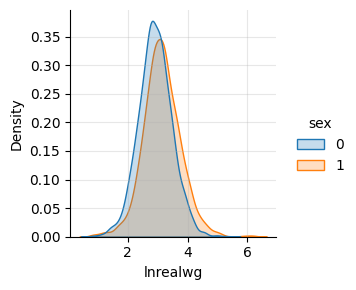

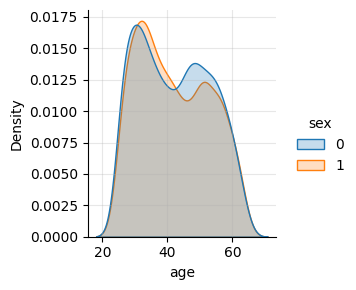

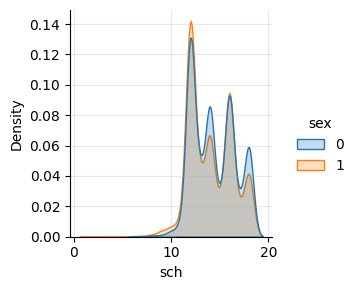

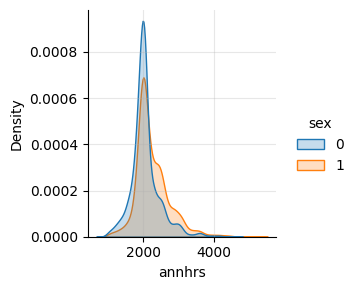

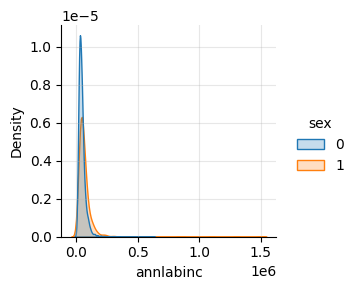

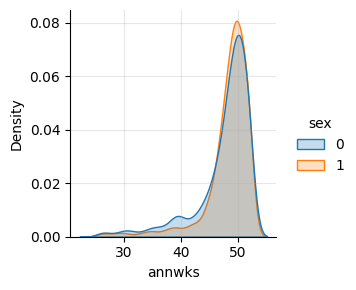

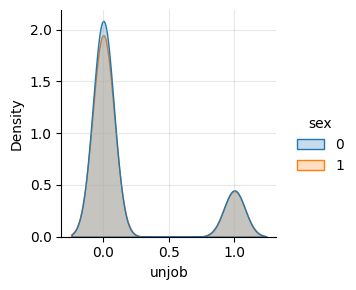

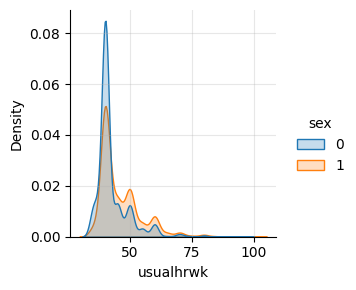

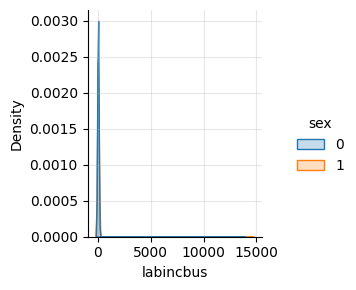

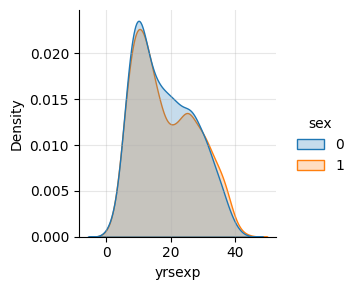

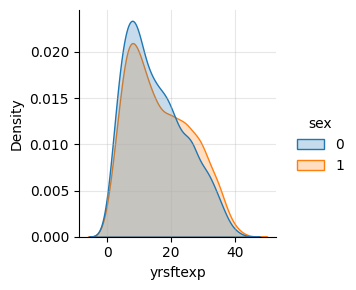

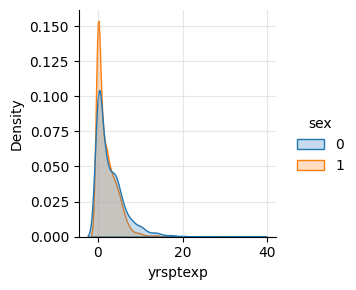

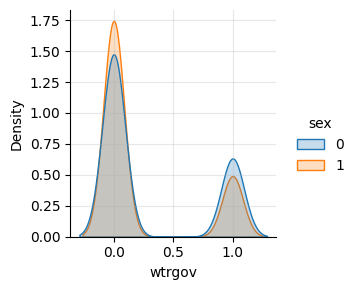

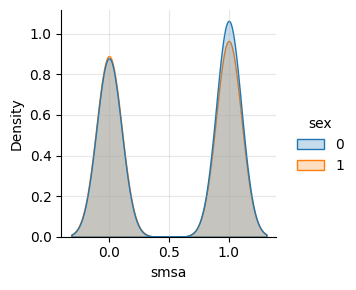

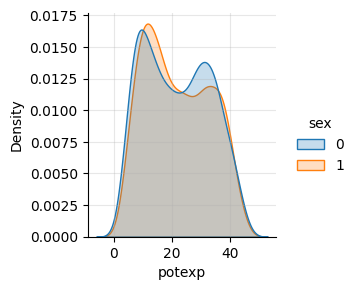

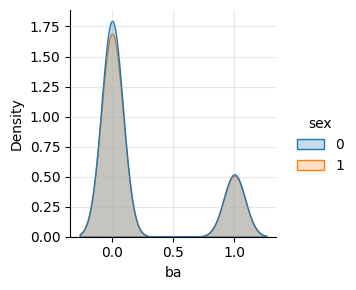

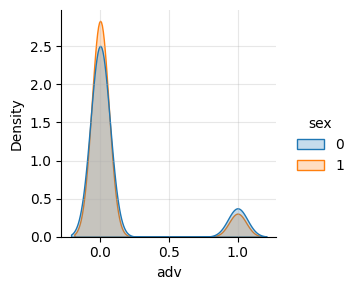

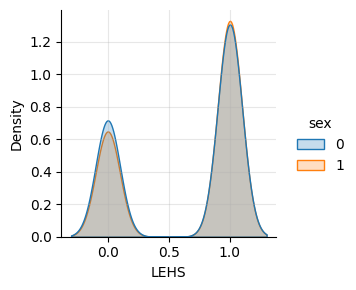

In [376]:
target = ['lnrealwg','age','sch','annhrs','annlabinc','annwks','unjob','usualhrwk','labincbus','yrsexp','yrsftexp','yrsptexp','wtrgov','smsa','potexp','ba','adv','LEHS']
for i in target:
    ax1 = sns.displot(adj_df, x=i, hue="sex", kind="kde", fill=True, height=3)
    plt.grid(alpha = 0.3)


In [380]:
# g = sns.FacetGrid(adj_df, col='Degree')
# g.map(sns.scatterplot, 'sex', 'lnrealwg', alpha=0.5)
# # g.set(ylim=(750, -10));

In [378]:
# g = sns.FacetGrid(adj_df, col='Degree', hue='sex')
# p1 = g.map(sns.distplot, 'lnrealwg')

In [379]:
# sns.pairplot(adj_df[['lnrealwg','sex','yrsexp','yrsftexp','yrsptexp','smsa']], hue="sex")

In [482]:
from statsmodels.formula.api import ols 
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.diagnostic as smd

Text(0.5, 1.0, 'Box-Cox Transformations for y (real wage per hour)')

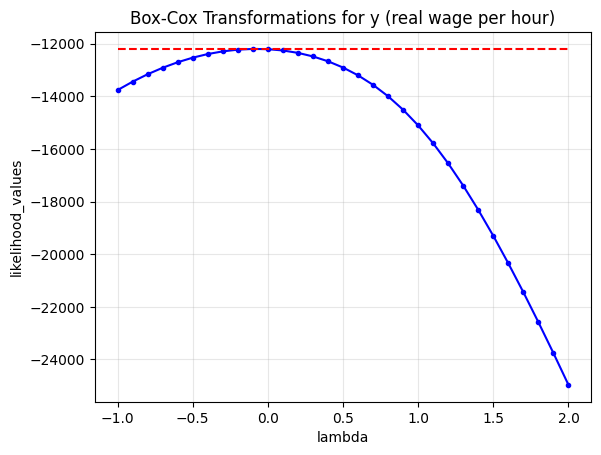

In [411]:
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df['realhrwage'])
lamb = np.linspace(-1, 2, 31)

likelihood_values = [stats.boxcox_llf(i, df['realhrwage']) for i in lamb]
plt.plot(lamb, likelihood_values, 'b.-')
plt.hlines(max(likelihood_values), -1, 2, colors='red', linestyles='--')
plt.grid(alpha = 0.3)
plt.xlabel('lambda')
plt.ylabel('likelihood_values')
plt.title('Box-Cox Transformations for y (real wage per hour)')
# plt.vlines(lamb[likelihood_values.index(max(likelihood_values))], -28000, max(likelihood_values))
# plt.ylim(-26000, -10000)

In [388]:
var_pool = ['lnrealwg', 'sex', 'age', 'sch', 'annhrs', 'white', 'black', 'hisp', 'othrace', 'annwks', 'unjob',
       'usualhrwk', 'labincbus', 'yrsexp', 'yrsftexp', 'yrsptexp', 'wtrgov', 'smsa',
       'northeast', 'northcentral', 'south', 'west', 'potexp', 'ba', 'adv', 'LEHS']

In [455]:
reg_data = adj_df[var_pool]
reg_data = pd.concat([reg_data, pd.get_dummies(adj_df['Industry'])*1, pd.get_dummies(adj_df['Degree'])*1, pd.get_dummies(adj_df['Relhead'])*1], axis=1)
reg_data.columns = [i.replace(" Occupations","").replace(" ","_").replace(",","").replace("’","") for i in reg_data.columns]

C:\Users\Wei\AppData\Local\Temp\ipykernel_33252\3014308072.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(8,3))


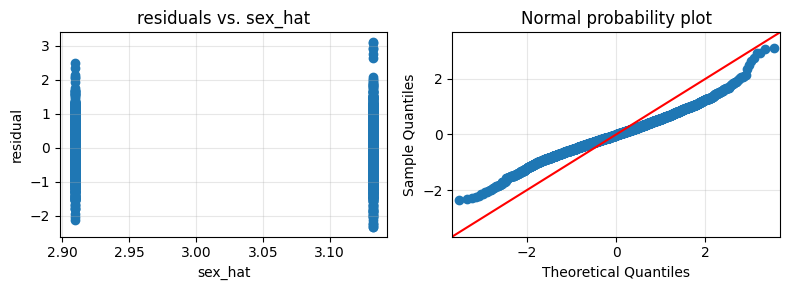

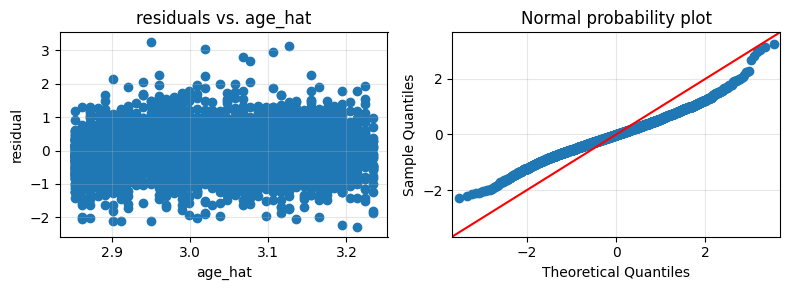

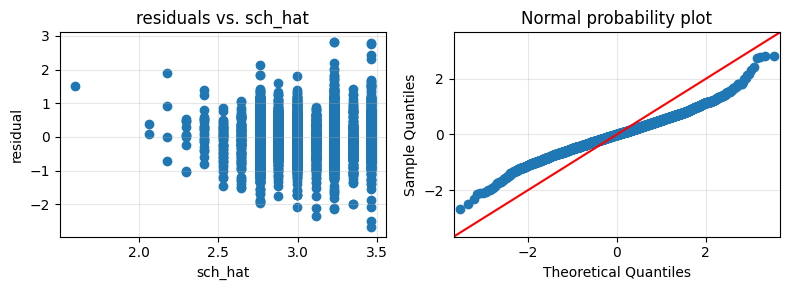

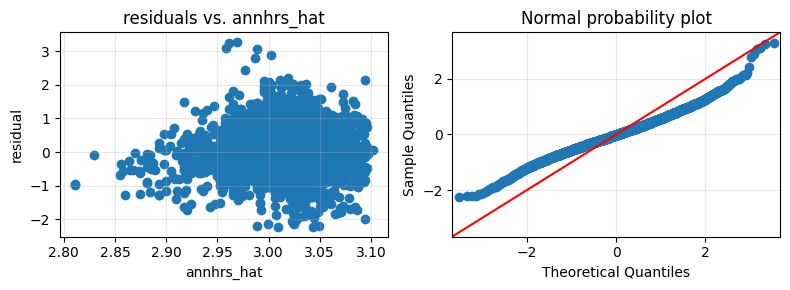

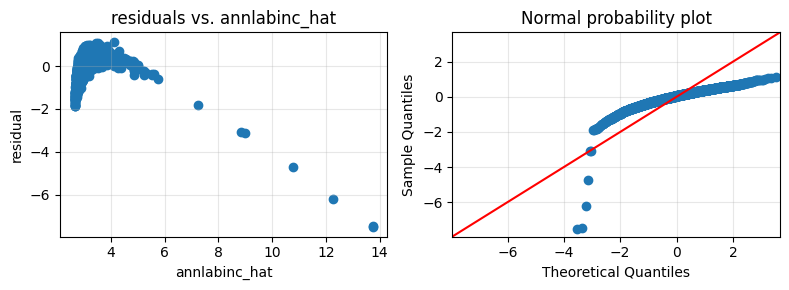

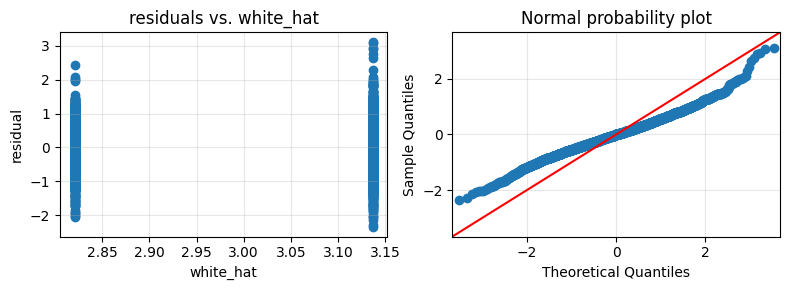

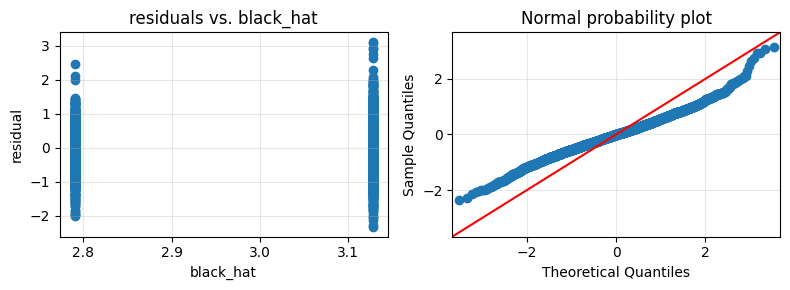

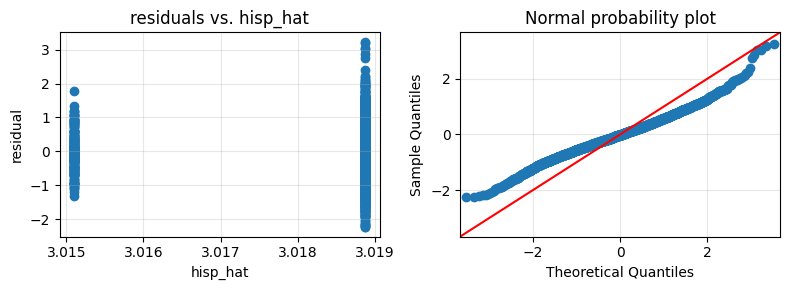

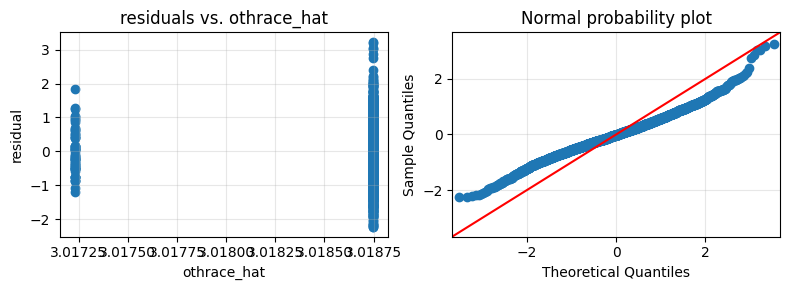

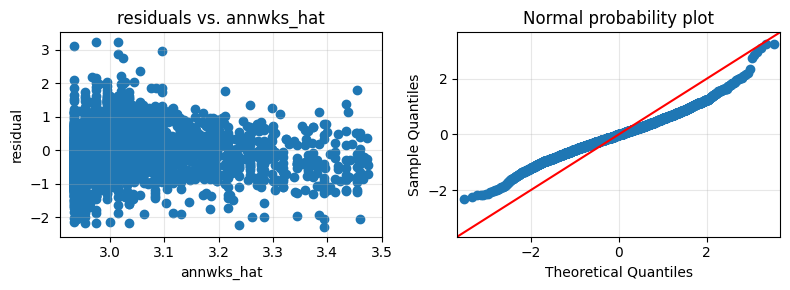

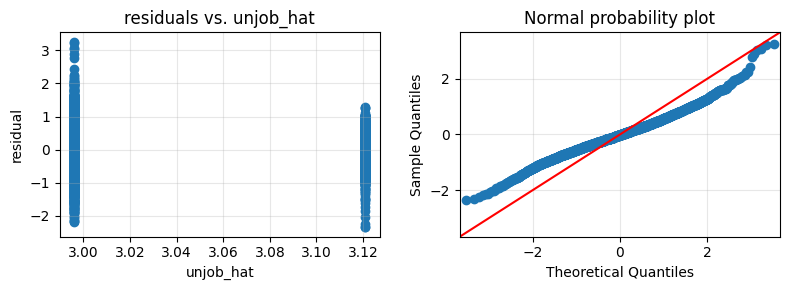

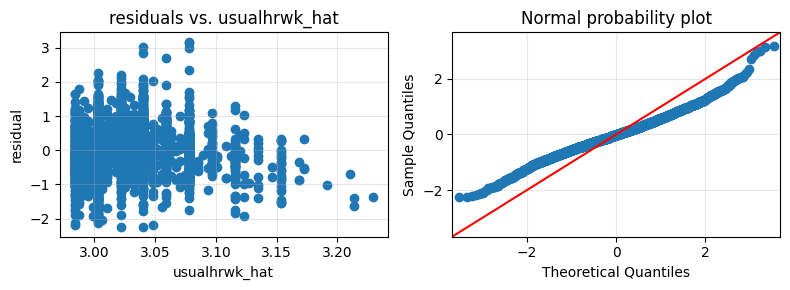

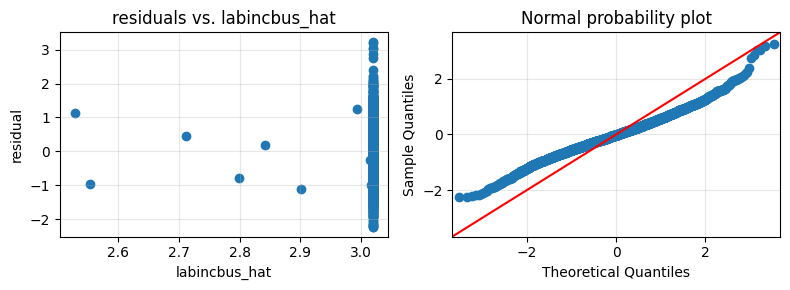

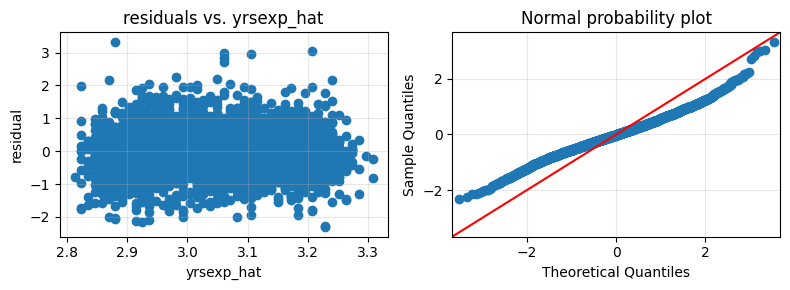

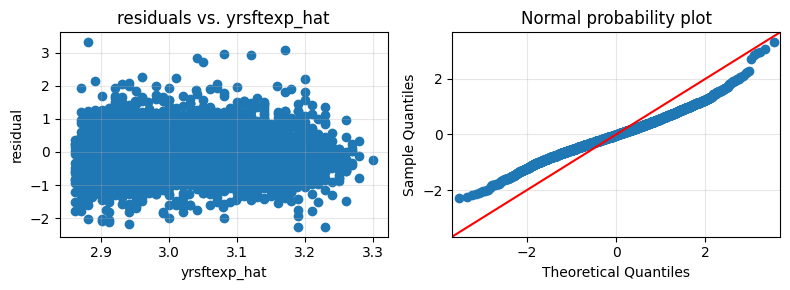

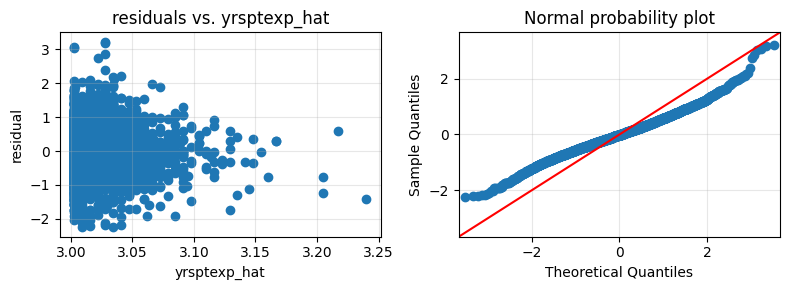

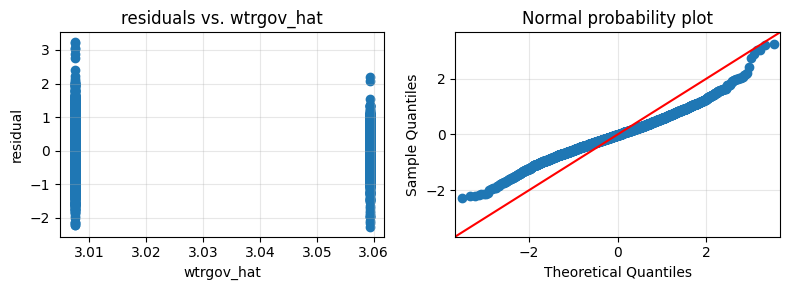

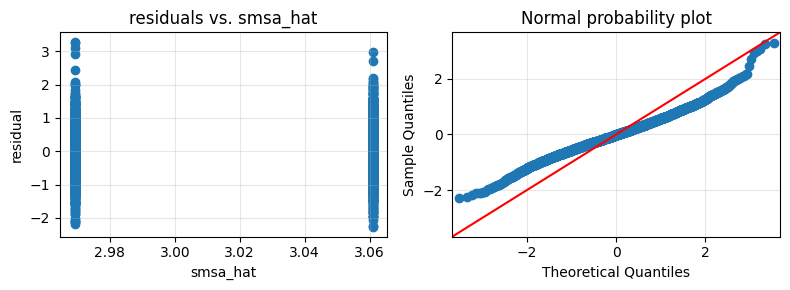

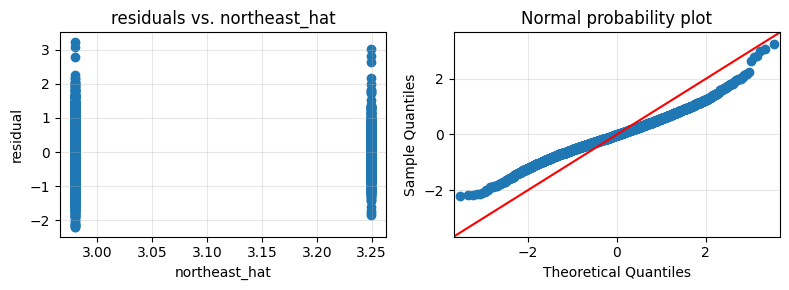

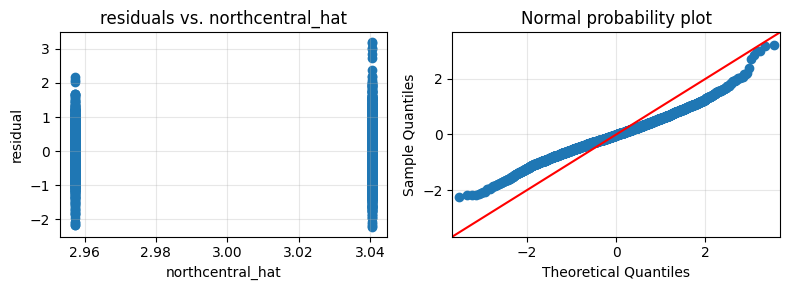

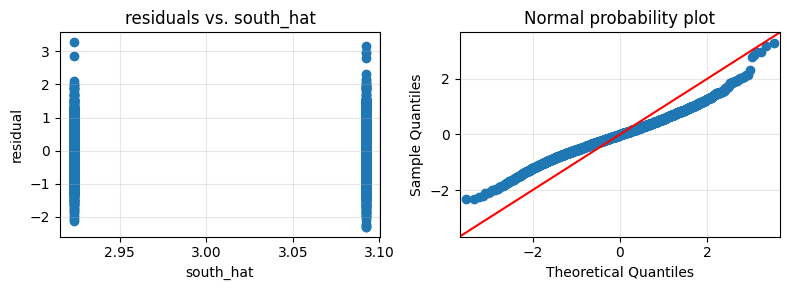

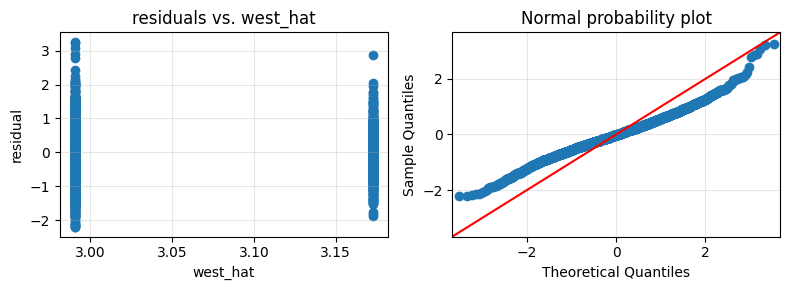

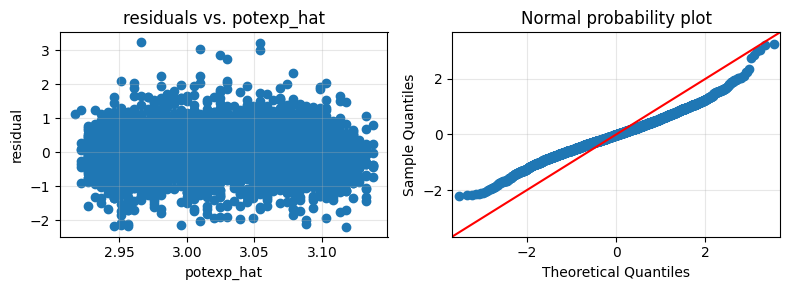

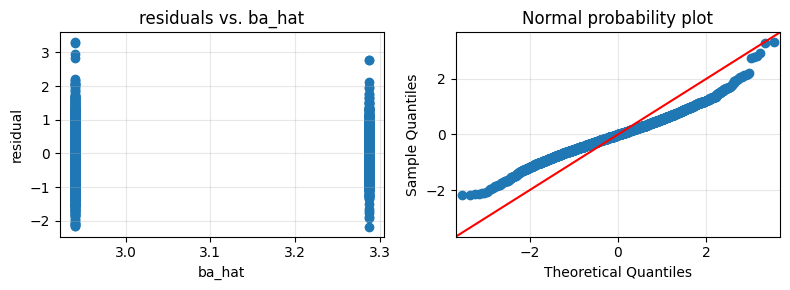

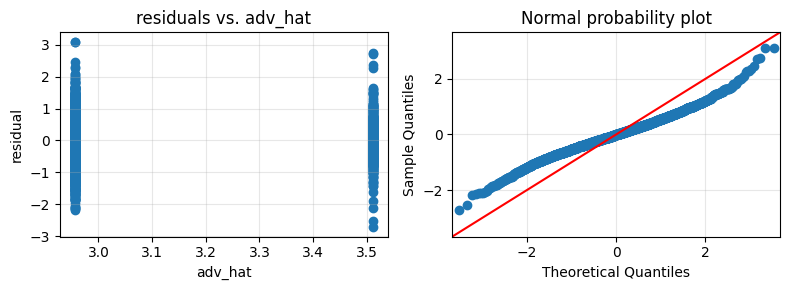

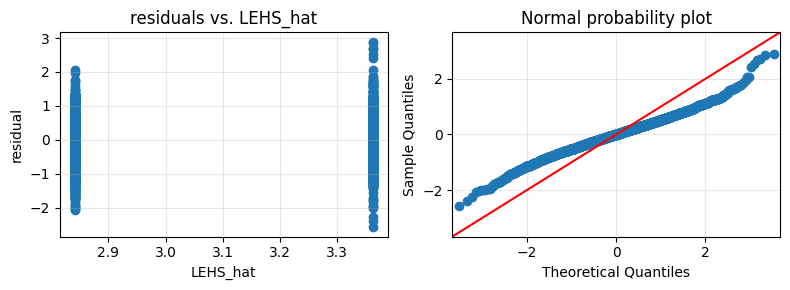

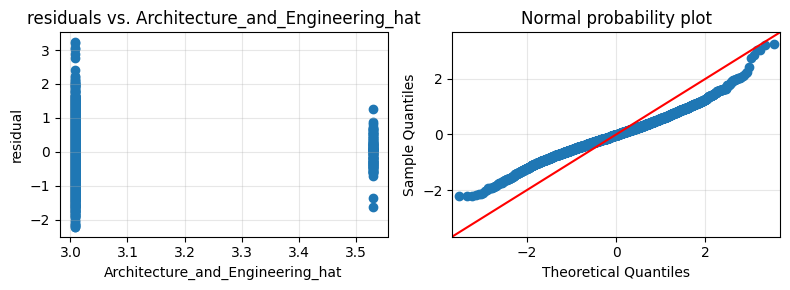

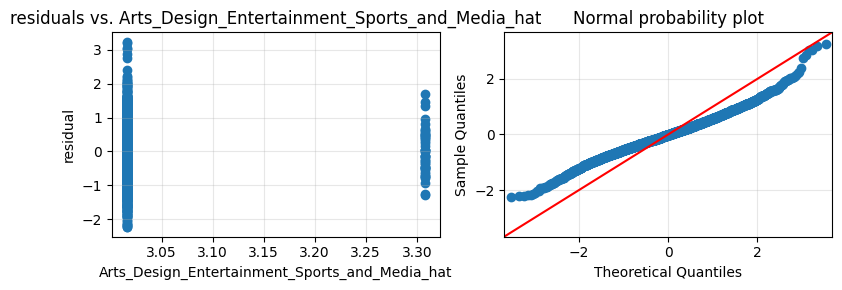

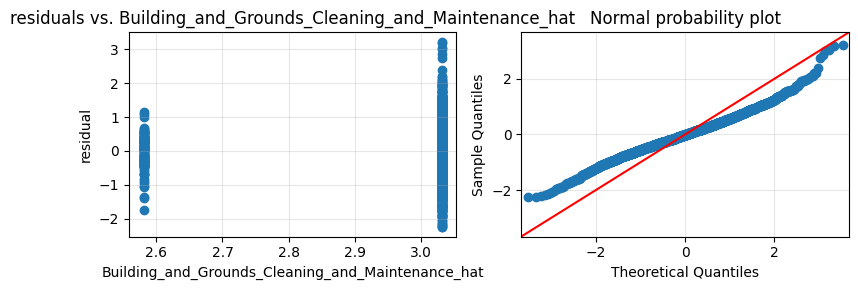

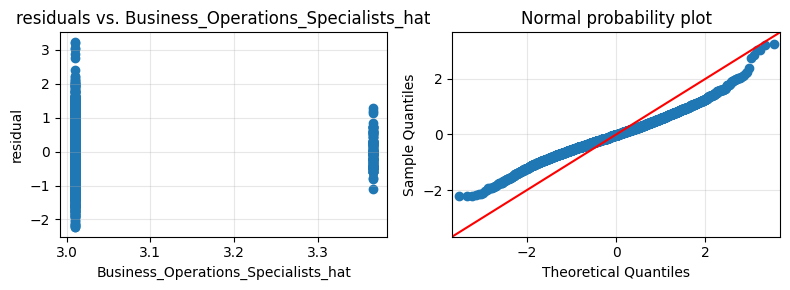

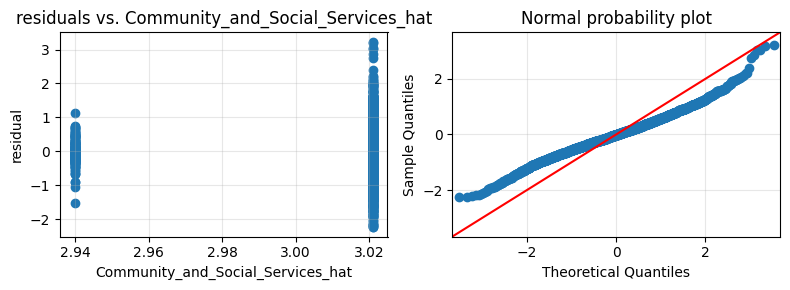

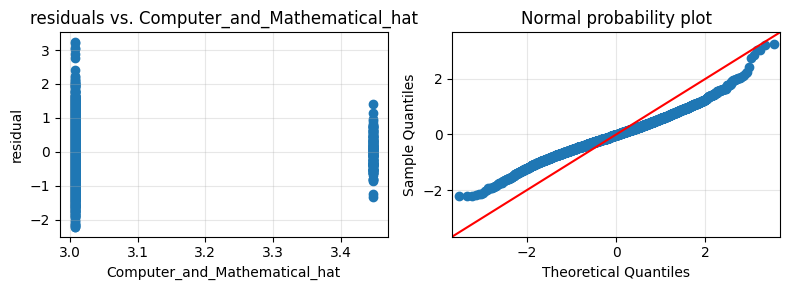

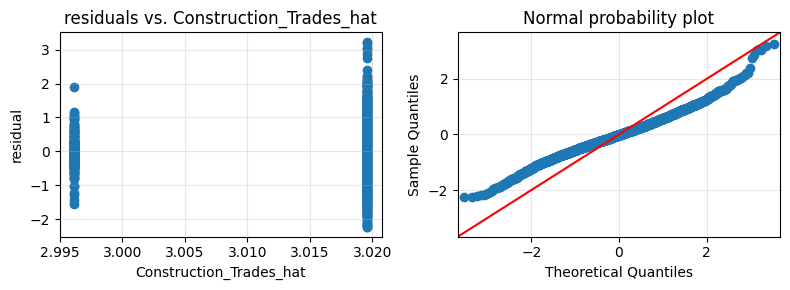

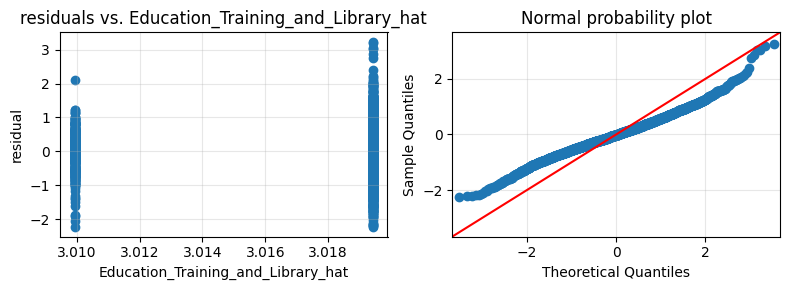

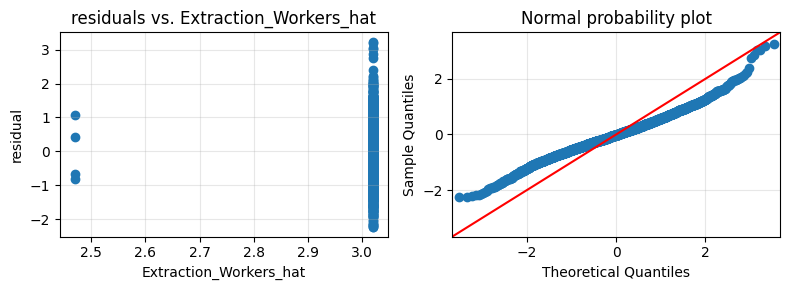

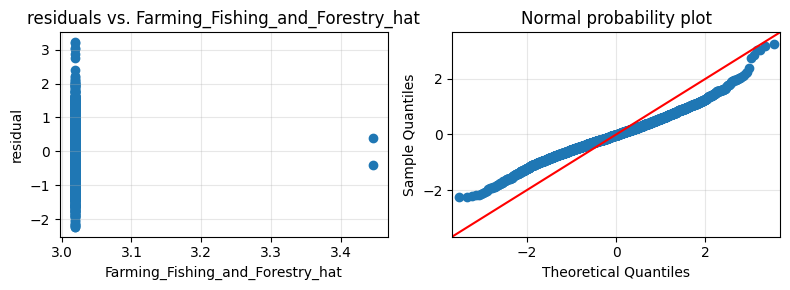

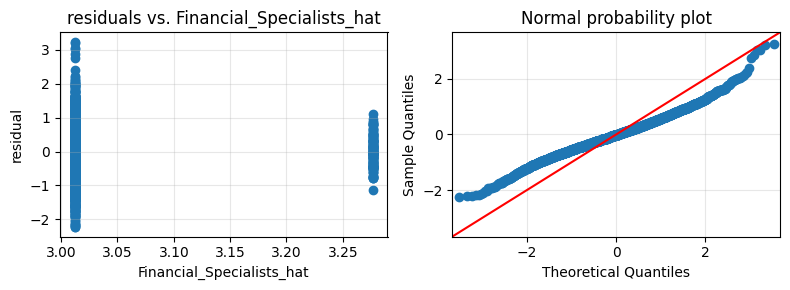

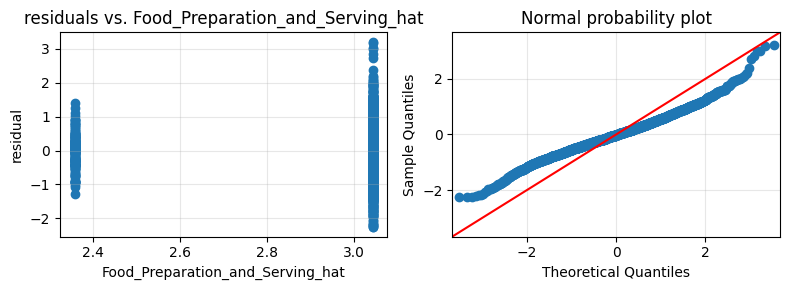

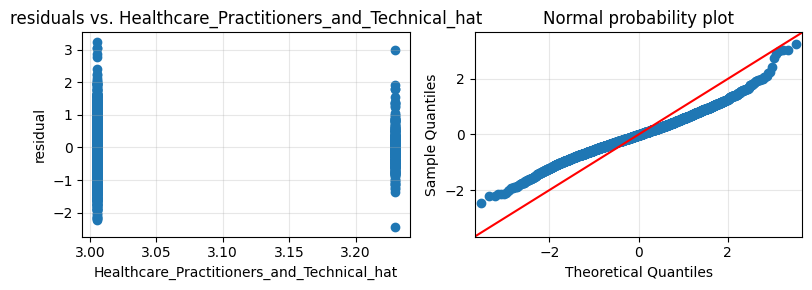

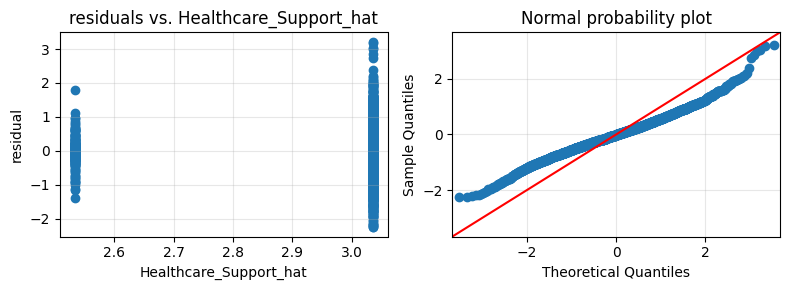

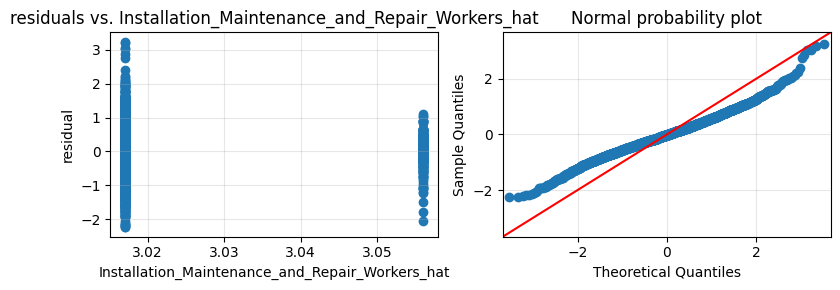

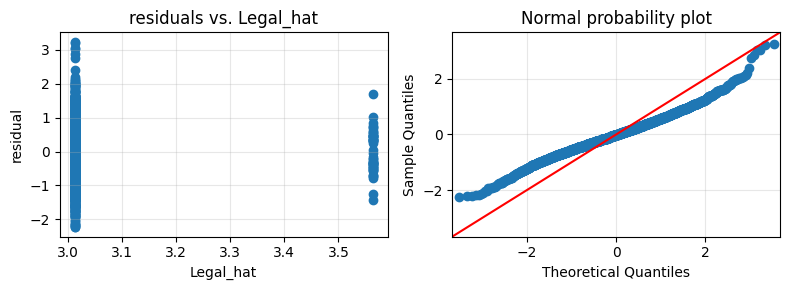

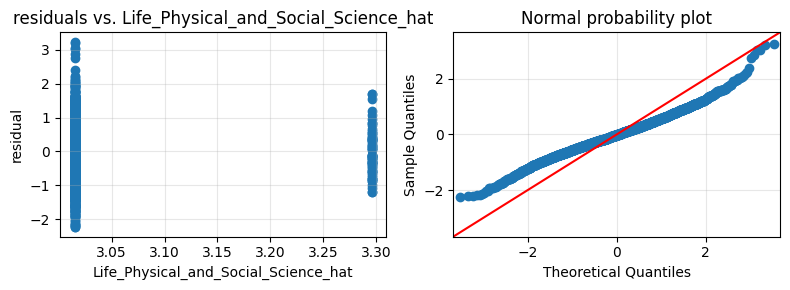

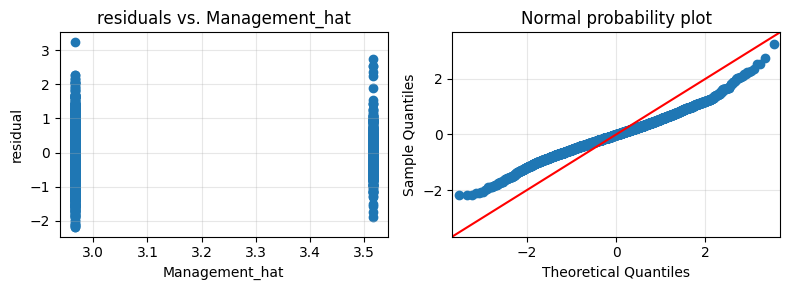

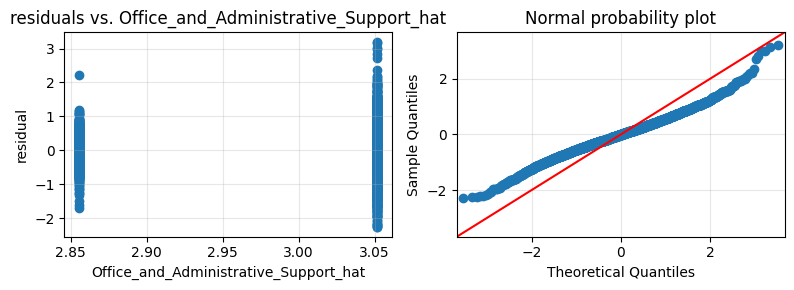

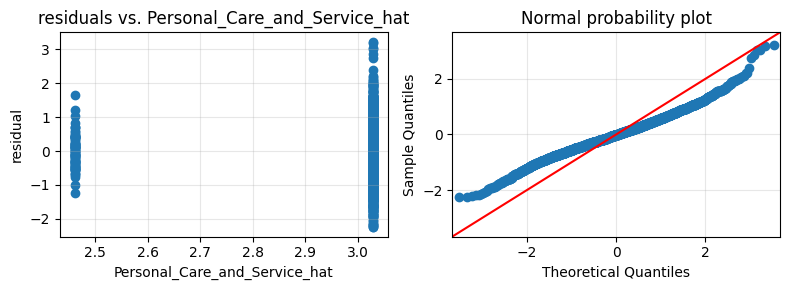

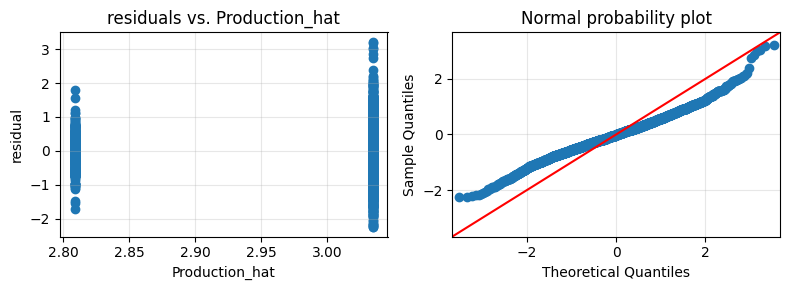

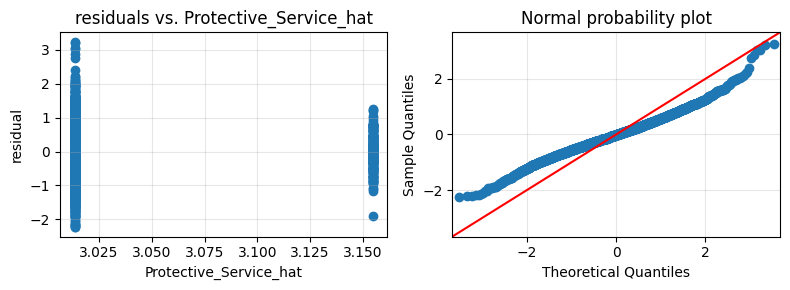

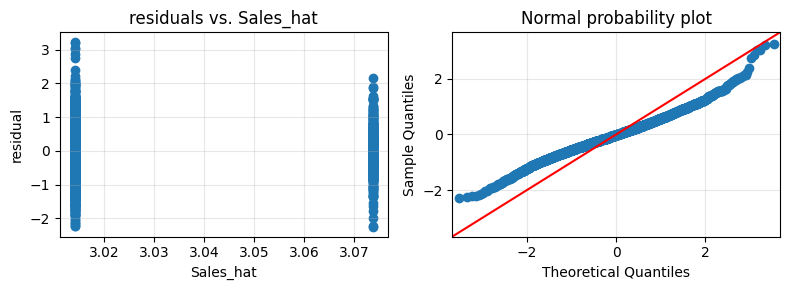

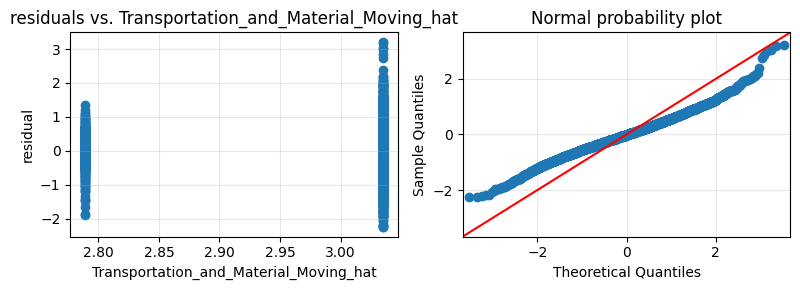

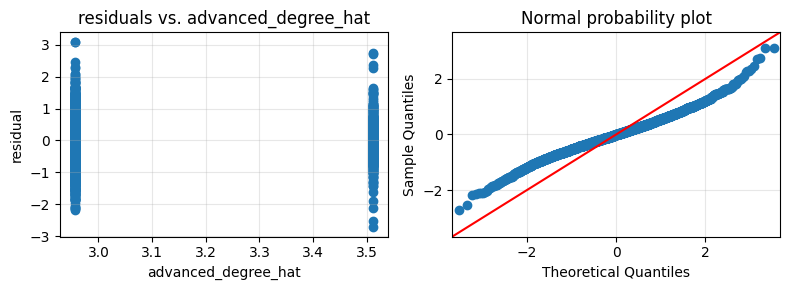

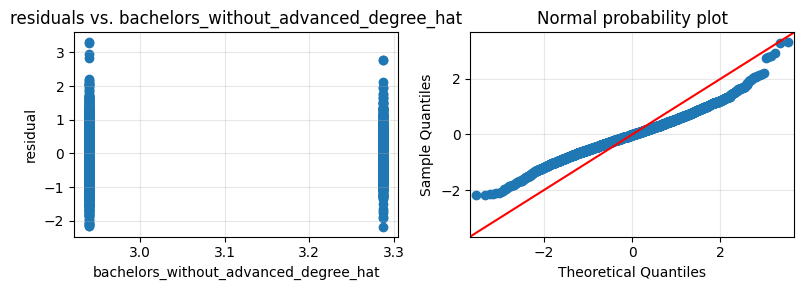

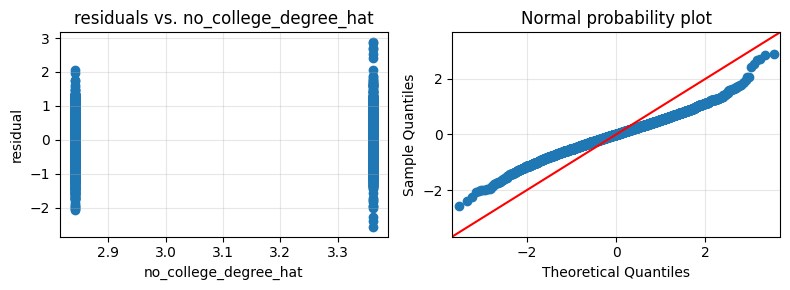

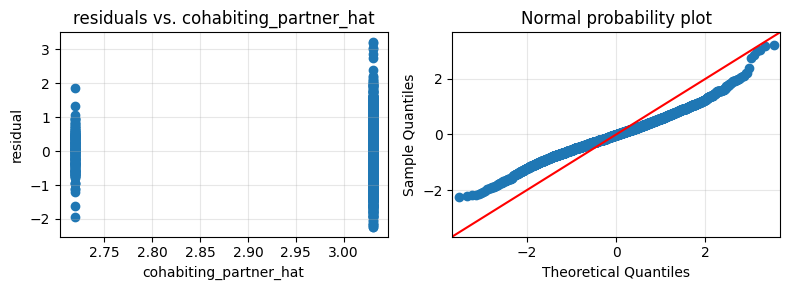

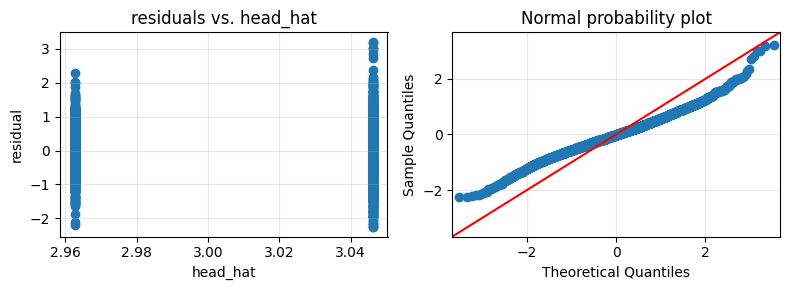

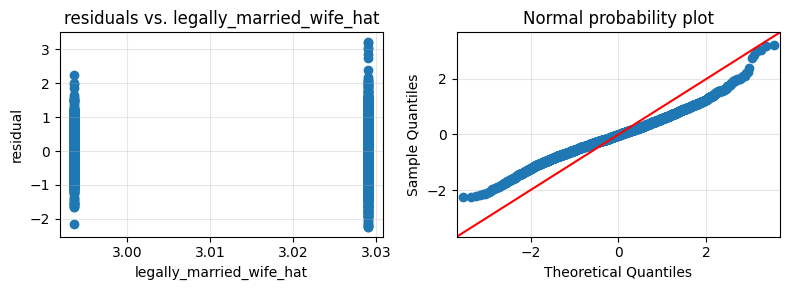

In [469]:
reg_result = []
reg_resid = {}
reg_fitval = {}
for i in reg_data.columns[1:]:
    reg_model = ols('lnrealwg ~ '+i, data=reg_data).fit()

    # beta
    beta = reg_model.params.iloc[1]
    # t-value
    tValue = reg_model.tvalues.iloc[1]
    # Durbin-Watson test statiitcs
    dwt = sms.durbin_watson(reg_model.resid)
    # Jarque-Bera test Chi^2 two-tail prob
    jbt = sms.jarque_bera(reg_model.resid)[1]
    # Breusch-Pagan Test p-value
    bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]
    reg_result.append([beta, abs(tValue), dwt, jbt, bpt])
    reg_fitval[i] = reg_model.fittedvalues
    reg_resid[i] = reg_model.resid
    
    # fig, axs = plt.subplots(1, 2, figsize=(8,3))

    # axs[0].scatter(reg_model.fittedvalues,reg_model.resid)
    # axs[0].grid(alpha = 0.3)
    # axs[0].set_title('residuals vs. '+reg_model.params.index[1]+'_hat')
    # axs[0].set_ylabel('residual')
    # axs[0].set_xlabel(reg_model.params.index[1]+'_hat')

    # sm.qqplot(reg_model.resid, line="45", ax=axs[1])
    # axs[1].grid(alpha = 0.3)
    # axs[1].set_title('Normal probability plot')
    # fig.tight_layout()

In [471]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [473]:
simple_reg_result = pd.DataFrame(reg_result, index=reg_data.columns[1:], columns=['beta','abs(tValue)','Durbin-Watson test','Jarque-Bera test (pValue)','Breusch-Pagan (pValue)']).sort_values('abs(tValue)', ascending=False)
simple_reg_result

beta  abs(tValue)  \
annlabinc                                      0.00        66.81   
sch                                            0.12        32.85   
LEHS                                          -0.52        30.80   
no_college_degree                             -0.52        30.73   
adv                                            0.56        20.97   
advanced_degree                                0.56        20.97   
Management                                     0.55        19.18   
black                                         -0.34        18.60   
white                                          0.32        17.97   
bachelors_without_advanced_degree              0.35        17.14   
ba                                             0.35        17.14   
Food_Preparation_and_Serving                  -0.69        14.98   
sex                                            0.22        12.92   
age                                            0.01        12.35   
yrsexp                                         0.01        12.14   
northeast                                      0.27        11.02   
yrsftexp                                       0.01        10.99   
annwks                                        -0.02        10.79   
Healthcare_Support                            -0.50        10.21   
south                                         -0.17         9.60   
Architecture_and_Engineering                   0.52         8.70   
Office_and_Administrative_Support             -0.20         8.41   
Building_and_Grounds_Cleaning_and_Maintenance -0.45         8.36   
Computer_and_Mathematical                      0.44         8.28   
Personal_Care_and_Service                     -0.57         8.19   
west                                           0.18         7.55   
Transportation_and_Material_Moving            -0.25         7.00   
cohabiting_partner                            -0.31         6.73   
Production                                    -0.23         6.60   
Business_Operations_Specialists                0.36         6.47   
Legal                                          0.55         6.37   
potexp                                         0.00         6.32   
Healthcare_Practitioners_and_Technical         0.22         6.04   
unjob                                          0.12         5.49   
smsa                                           0.09         5.23   
Financial_Specialists                          0.26         4.76   
head                                           0.08         4.48   
northcentral                                  -0.08         4.20   
Life_Physical_and_Social_Science               0.28         3.66   
annhrs                                        -0.00         3.59   
usualhrwk                                      0.00         3.42   
Arts_Design_Entertainment_Sports_and_Media     0.29         3.30   
Protective_Service                             0.14         3.04   
wtrgov                                         0.05         2.59   
yrsptexp                                       0.01         2.37   
legally_married_wife                          -0.04         1.84   
Sales                                          0.06         1.83   
Extraction_Workers                            -0.55         1.80   
Community_and_Social_Services                 -0.08         1.52   
labincbus                                     -0.00         1.32   
Farming_Fishing_and_Forestry                   0.43         0.99   
Installation_Maintenance_and_Repair_Workers    0.04         0.89   
Construction_Trades                           -0.02         0.50   
Education_Training_and_Library                -0.01         0.28   
hisp                                          -0.00         0.08   
othrace                                       -0.00         0.02   

                                               Durbin-Watson test  \
annlabinc                                                    1.97   
sch                             

C:\Users\Wei\AppData\Local\Temp\ipykernel_33252\898087964.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(8,3))


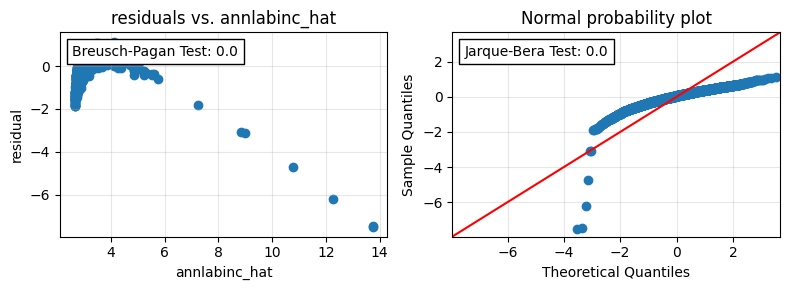

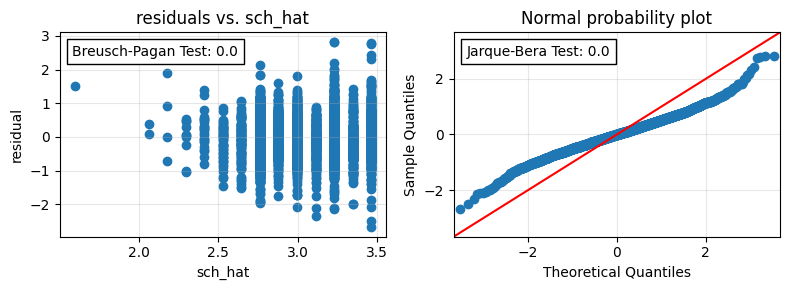

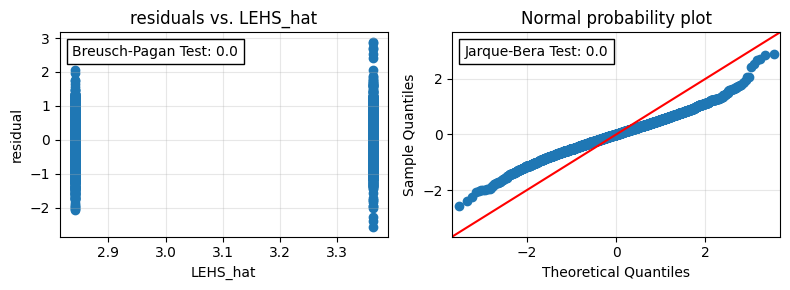

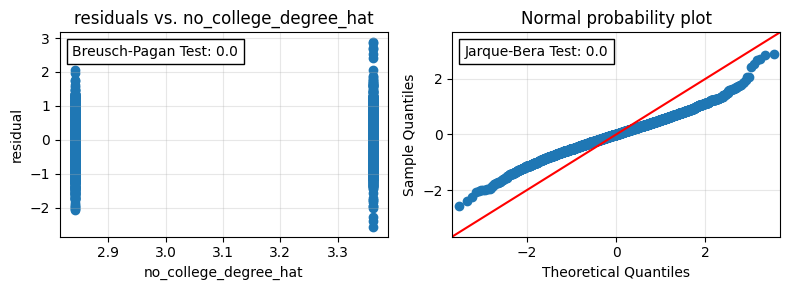

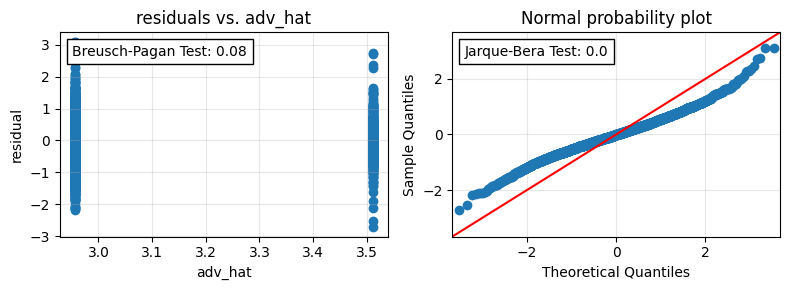

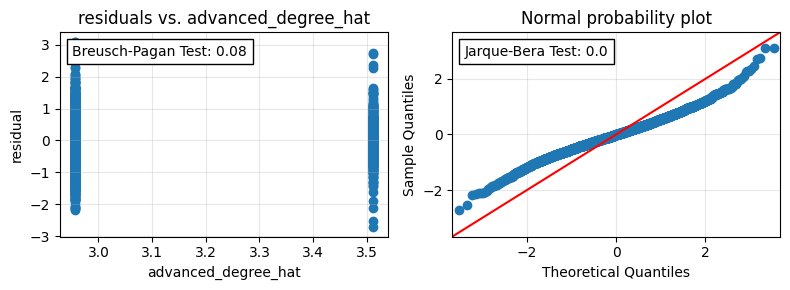

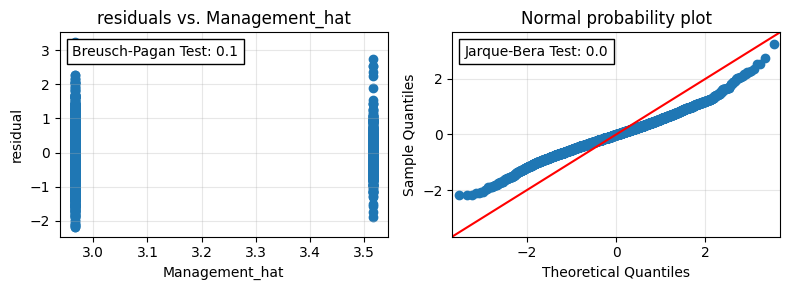

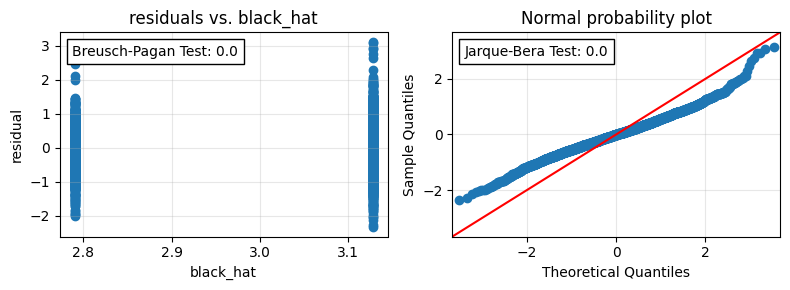

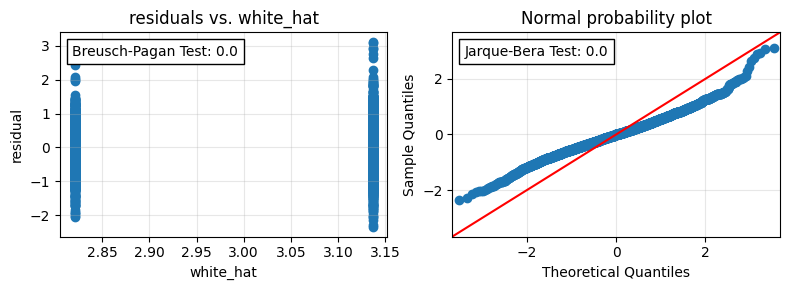

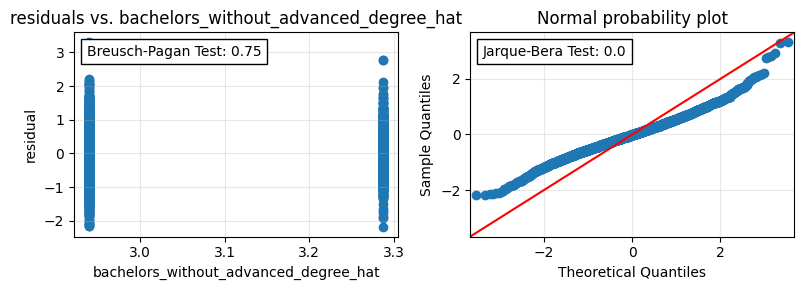

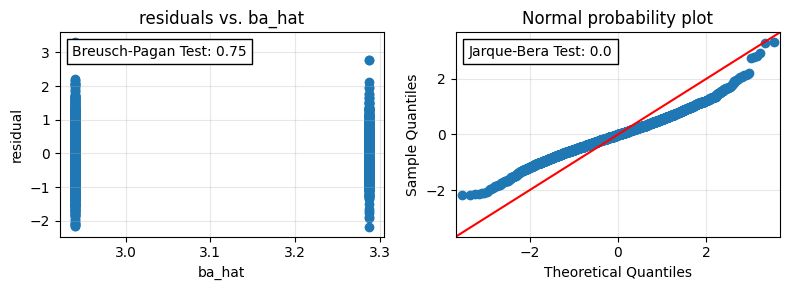

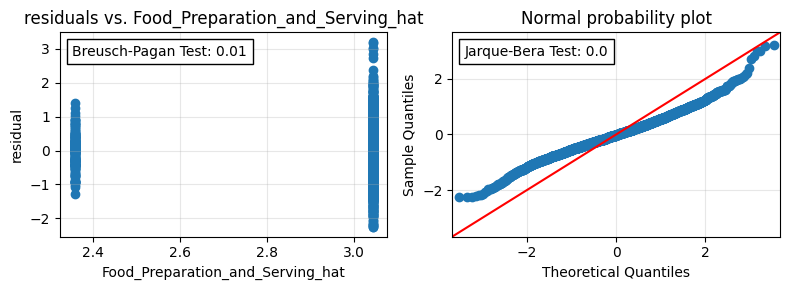

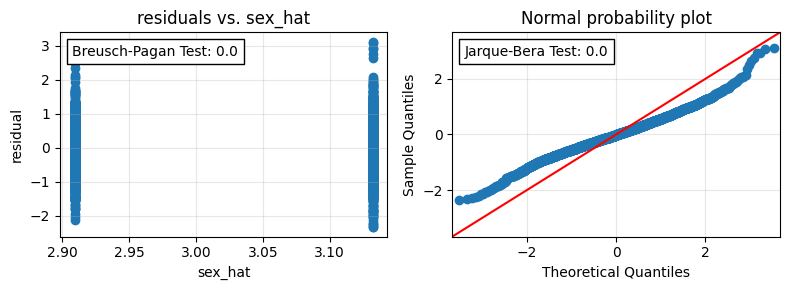

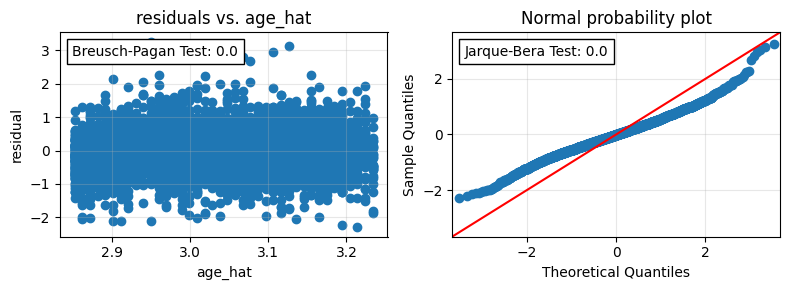

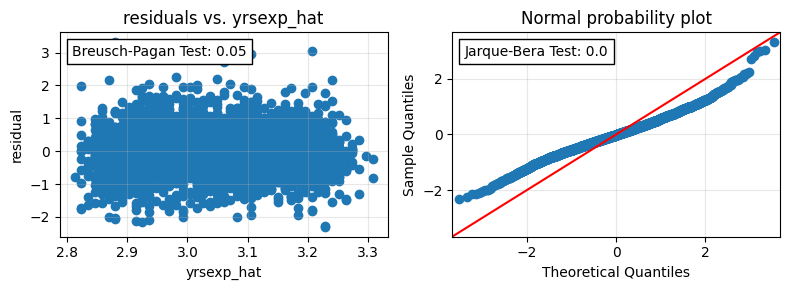

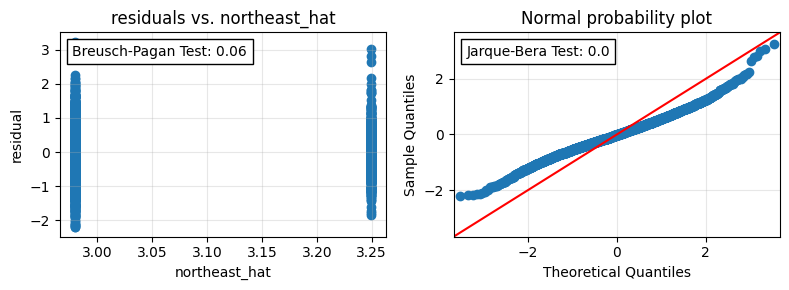

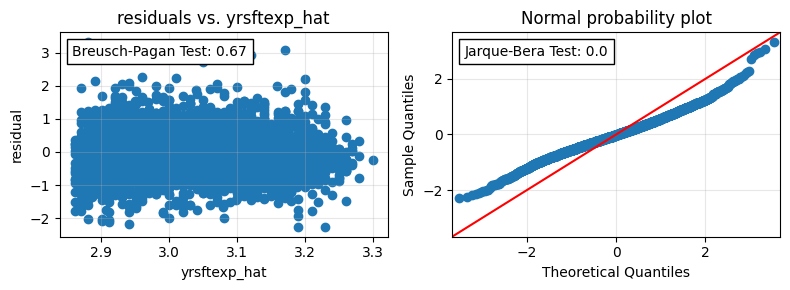

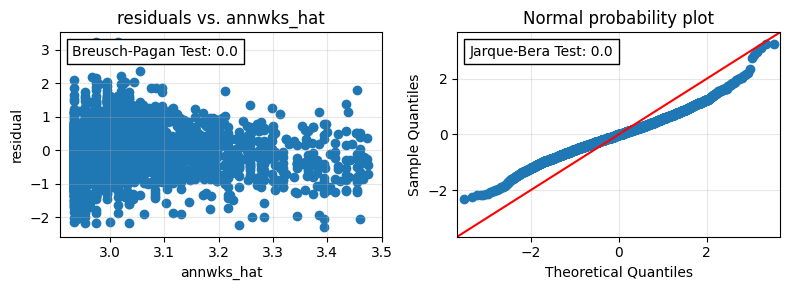

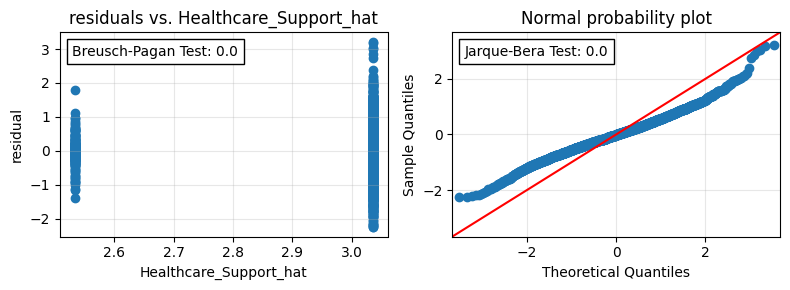

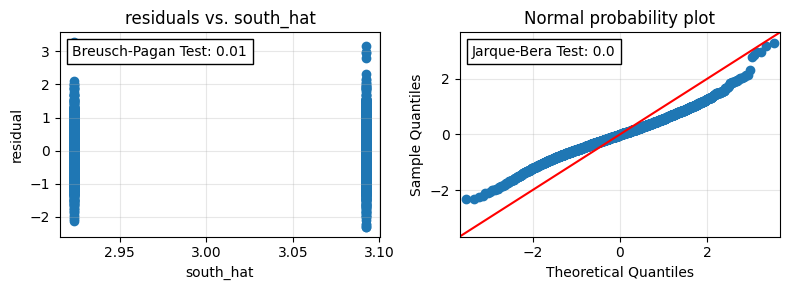

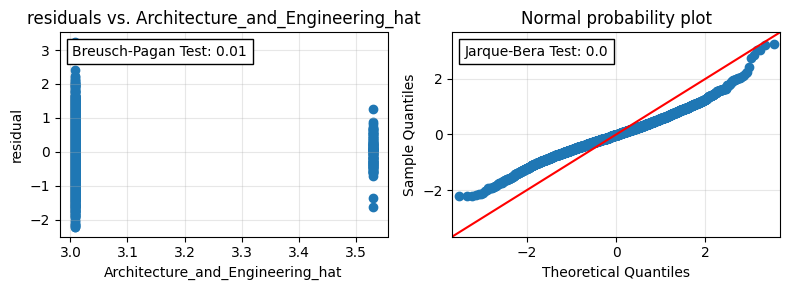

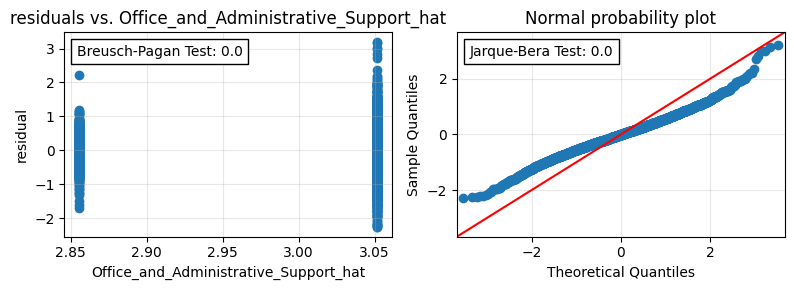

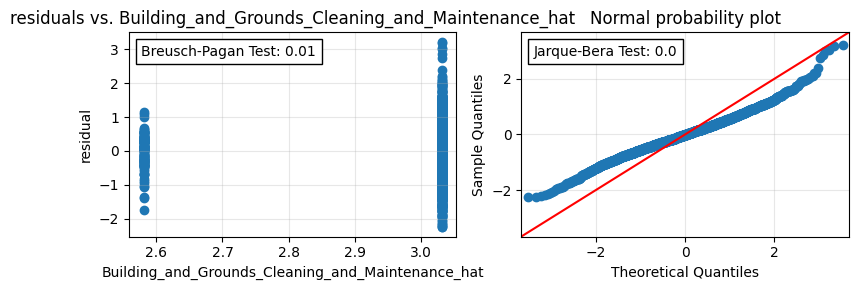

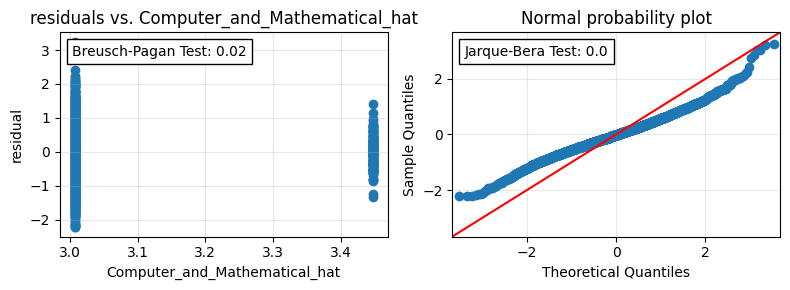

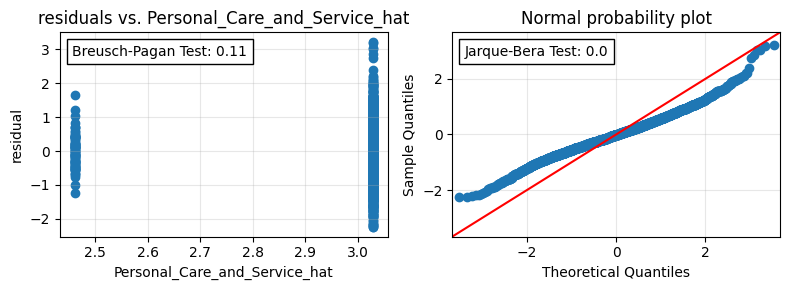

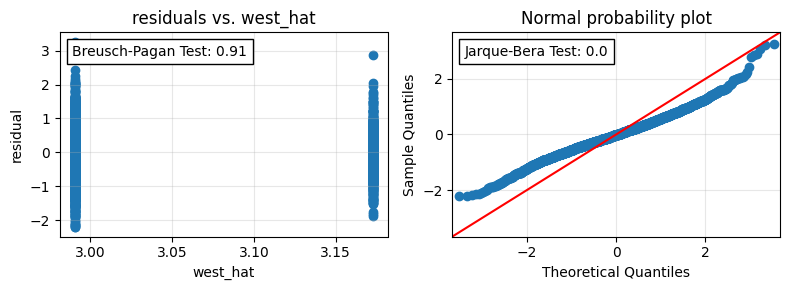

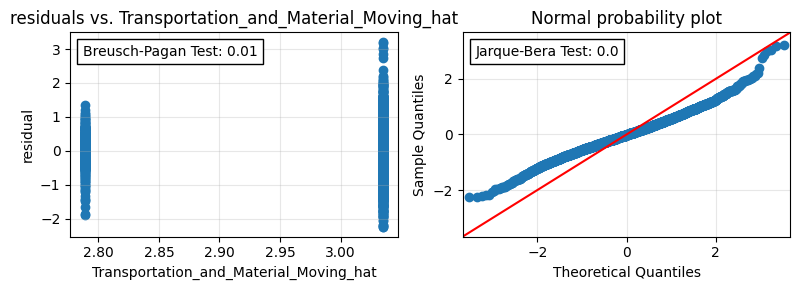

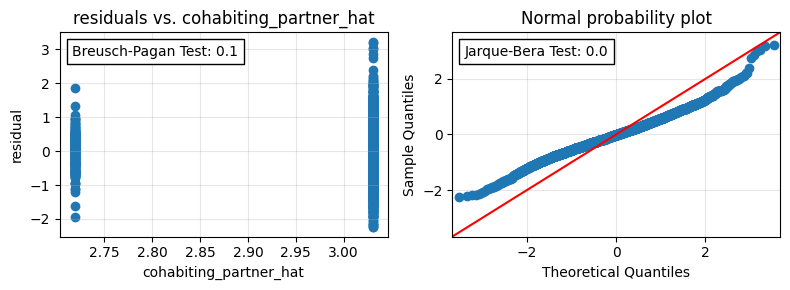

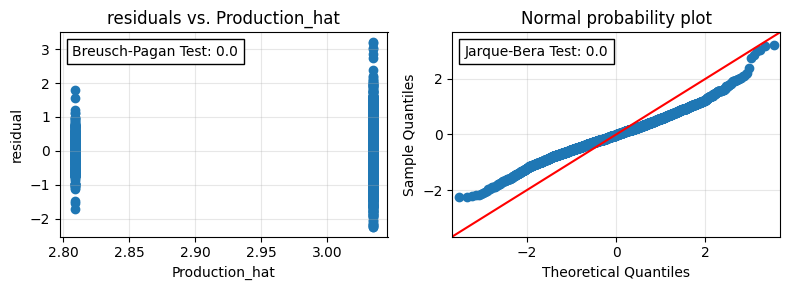

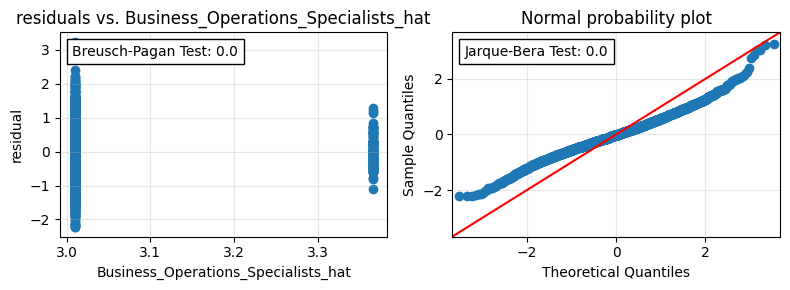

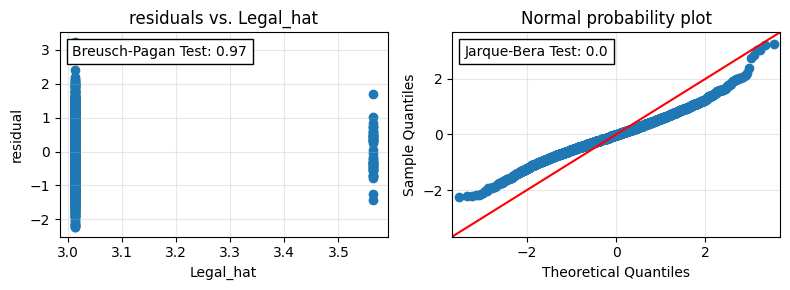

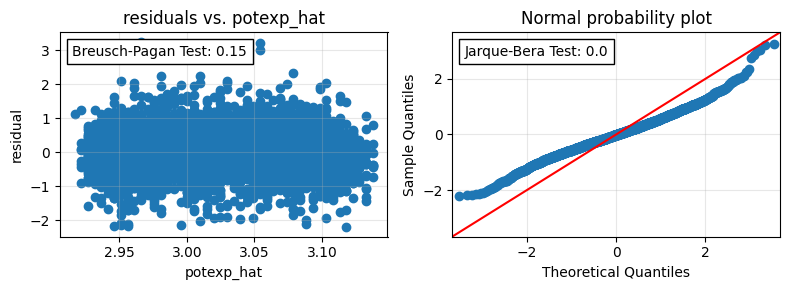

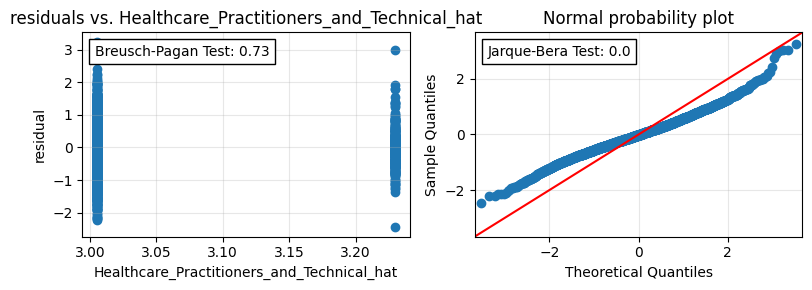

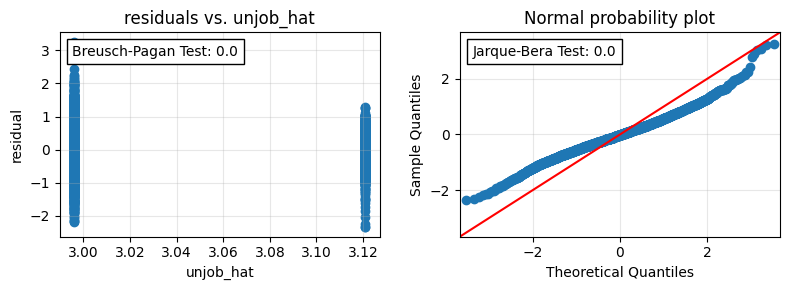

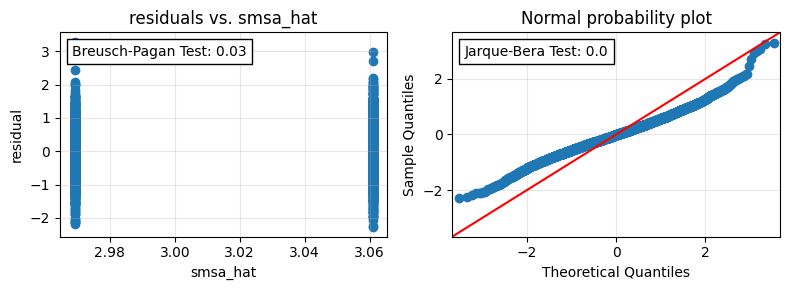

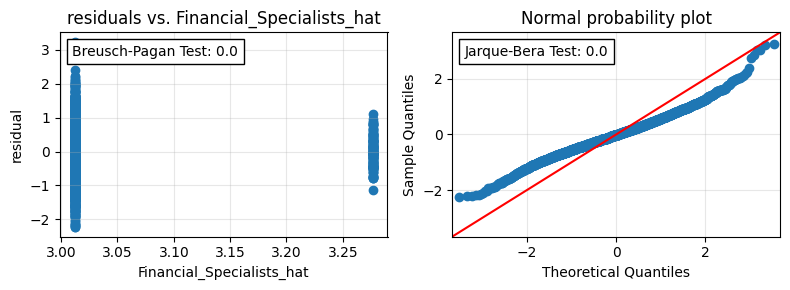

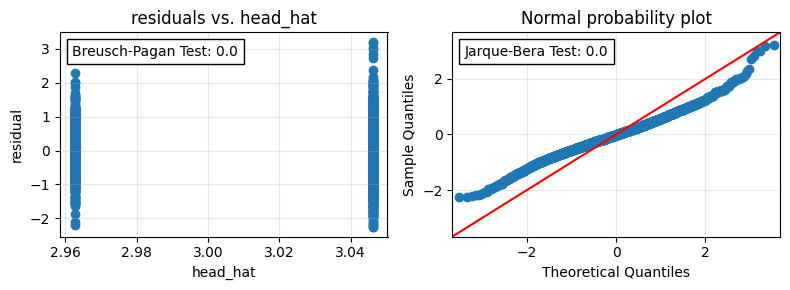

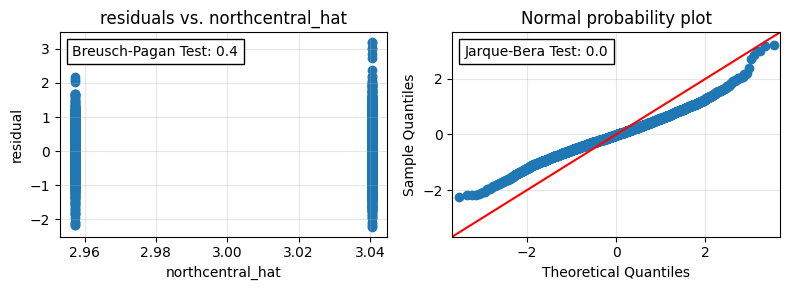

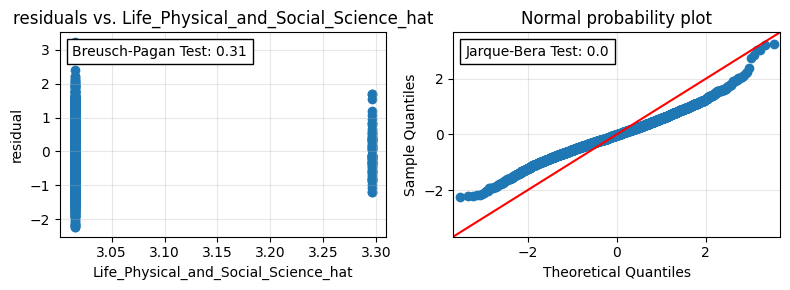

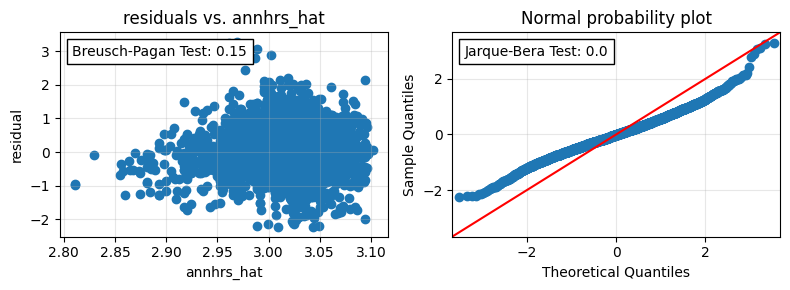

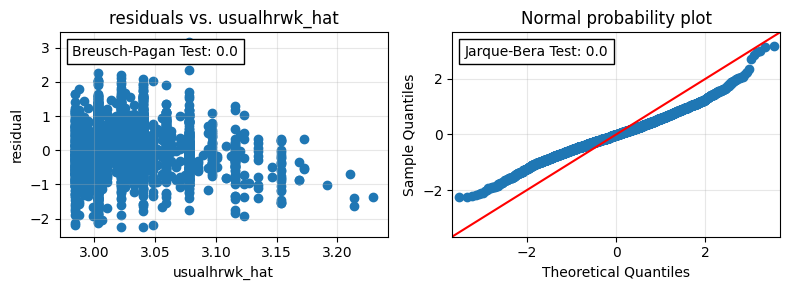

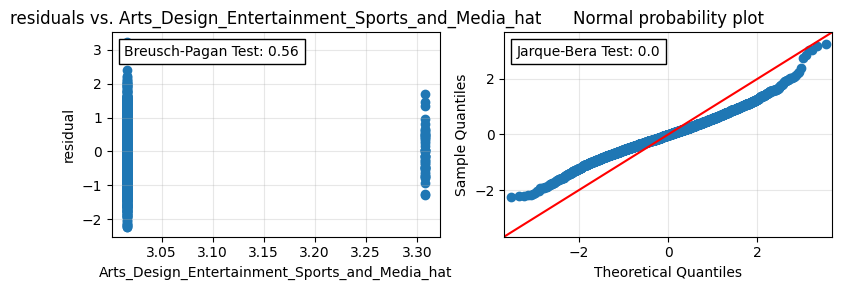

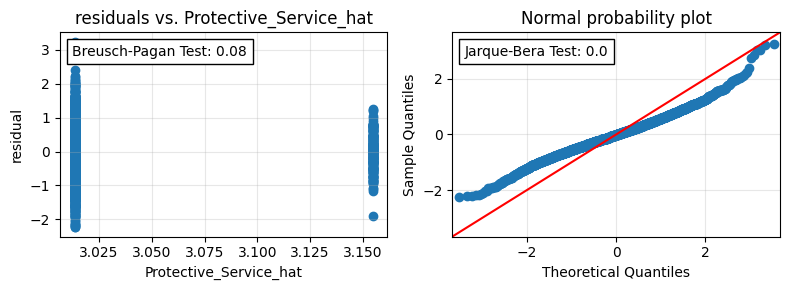

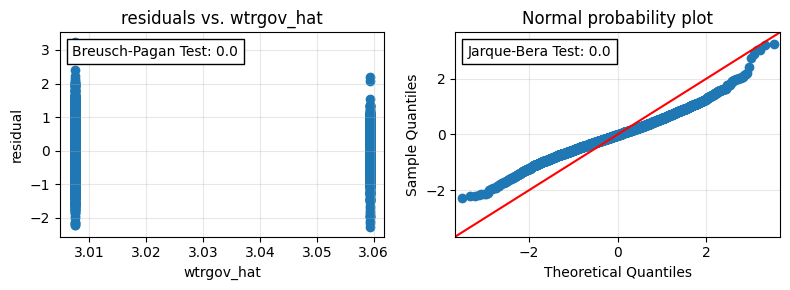

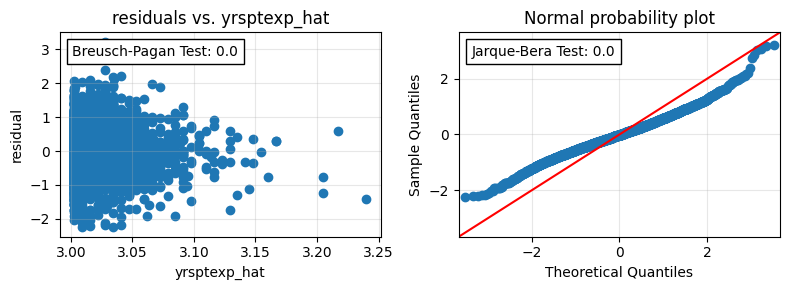

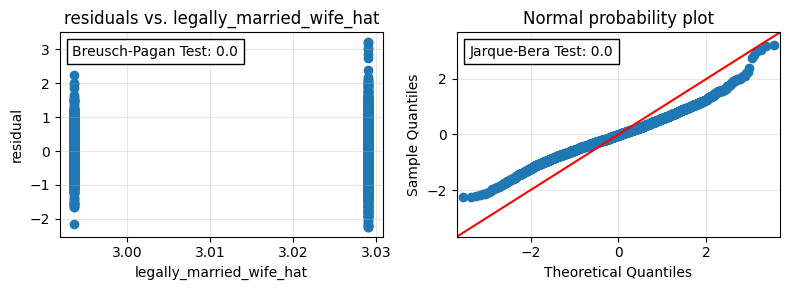

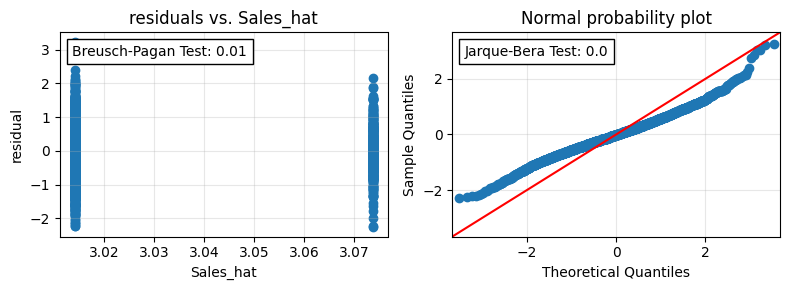

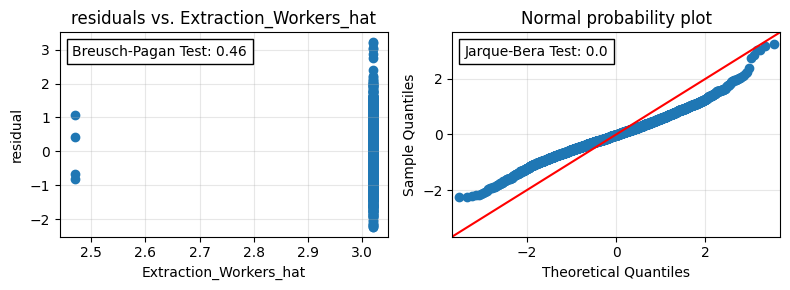

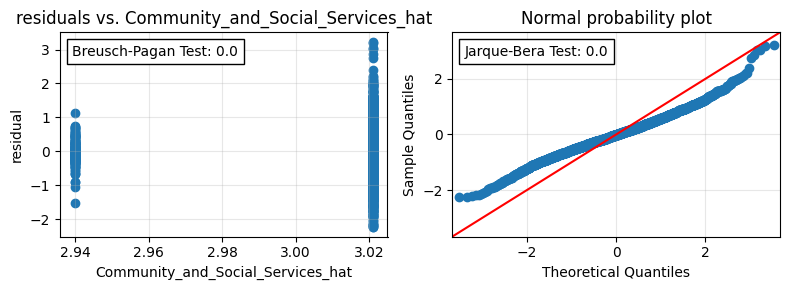

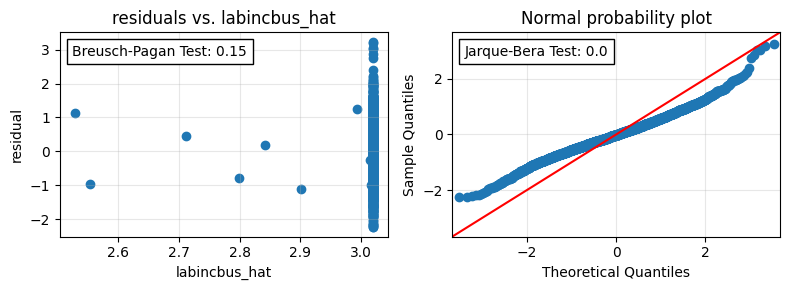

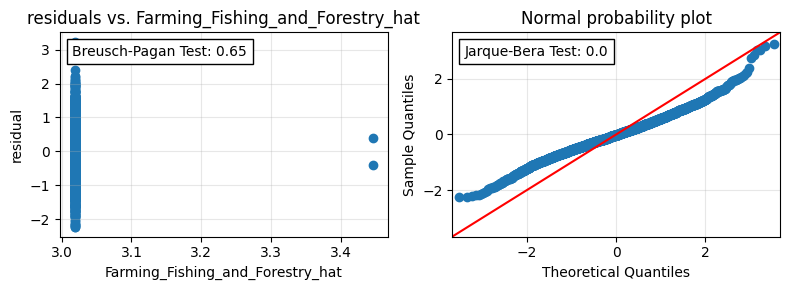

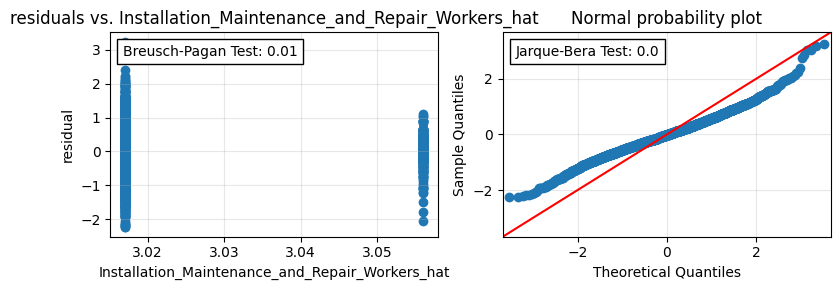

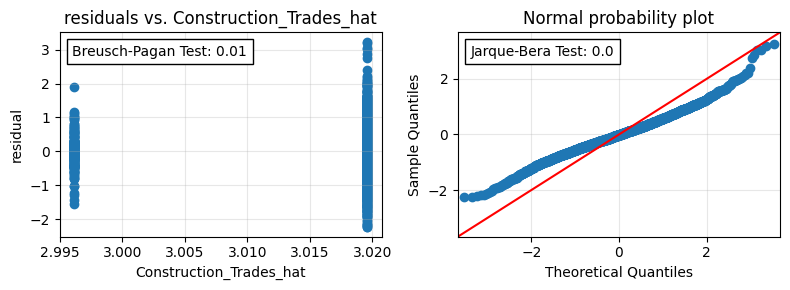

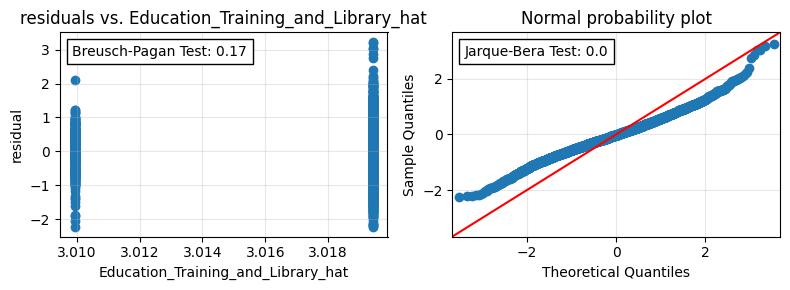

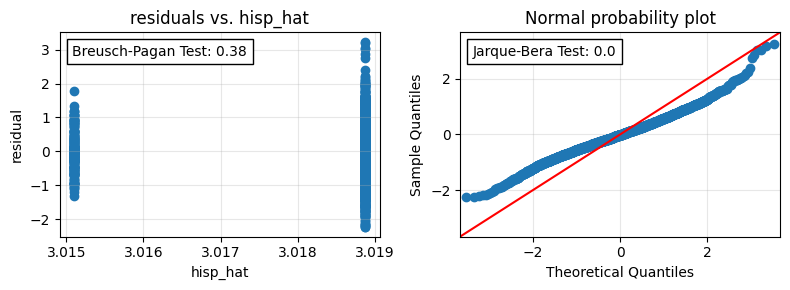

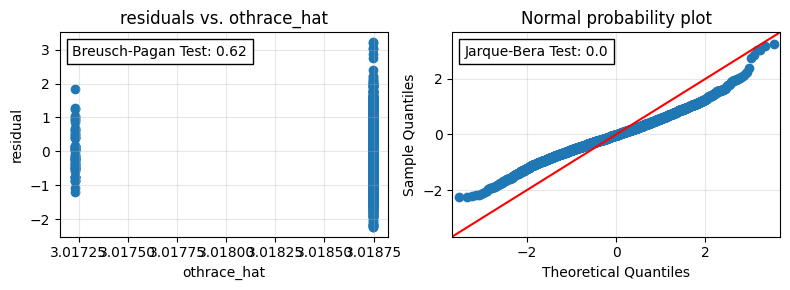

In [487]:
from matplotlib.offsetbox import AnchoredText
for i in simple_reg_result.index:
        fig, axs = plt.subplots(1, 2, figsize=(8,3))

        axs[0].scatter(reg_fitval[i], reg_resid[i])
        axs[0].grid(alpha = 0.3)
        axs[0].set_title('residuals vs. '+i+'_hat')
        axs[0].set_ylabel('residual')
        axs[0].set_xlabel(i+'_hat')
        anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(simple_reg_result.loc[i,'Breusch-Pagan (pValue)'],2)), loc=2)
        axs[0].add_artist(anchored_text)


        sm.qqplot(reg_resid[i], line="45", ax=axs[1])
        axs[1].grid(alpha = 0.3)
        axs[1].set_title('Normal probability plot')
        anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(simple_reg_result.loc[i,'Jarque-Bera test (pValue)'],2)), loc=2)
        axs[1].add_artist(anchored_text)
        fig.tight_layout()

In [481]:
# name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
# test = sms.jarque_bera(reg_model.resid)
# lzip(name, test)
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 23.045828444511308),
 ('p-value', 1.5818535653327714e-06),
 ('f-value', 23.14660200987616),
 ('f p-value', 1.5467509709605432e-06)]

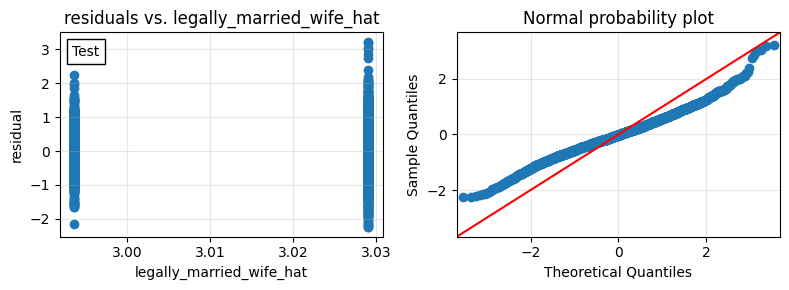

In [477]:
from matplotlib.offsetbox import AnchoredText
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(reg_model.fittedvalues,reg_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. '+reg_model.params.index[1]+'_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel(reg_model.params.index[1]+'_hat')
anchored_text = AnchoredText("Test", loc=2)
axs[0].add_artist(anchored_text)


sm.qqplot(reg_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
fig.tight_layout()

In [484]:
smd.het_breuschpagan(reg_model.resid, reg_model.model.exog)

(23.045828444511308,
 1.5818535653327714e-06,
 23.14660200987616,
 1.5467509709605432e-06)

In [238]:
sm.stats.anova_lm(reg_model, typ=1) 

df       sum_sq    mean_sq           F        PR(>F)
yrsftexp     1.0    43.804850  43.804850  121.482090  6.428841e-28
age          1.0    11.639557  11.639557   32.279479  1.413399e-08
Residual  4833.0  1742.716474   0.360587         NaN           NaN